# Notebook 04: Clasificacion de Nodulos Pulmonares

Este notebook entrena clasificadores de nodulos pulmonares (benigno/maligno) usando datos de LUNA16 + anotaciones LIDC-IDRI.

## Problema: Dataset Muy Pequeno (~164 patches)

Con tan pocas muestras, las redes profundas tienden a:
- **Overfitting**: Memorizan el train set
- **Alta varianza**: Metricas inestables entre splits

## Estrategias Implementadas

| Estrategia | Descripcion |
|------------|-------------|
| **K-Fold CV por paciente** | Evaluacion robusta, evita data leakage |
| **Backbone congelado** | Solo entrenar cabeza lineal (~1000 params vs 4M) |
| **Features + SVM/LogReg** | Clasificadores clasicos sobre embeddings |
| **Radiomics baseline** | Features interpretables de textura/forma |

## Contenido
1. Extraccion de Patches (LUNA16 + LIDC-IDRI)
2. **K-Fold Cross-Validation por paciente**
3. **Backbone congelado + cabeza lineal**
4. **Embeddings + clasificadores clasicos**
5. **Radiomics baseline**
6. Comparacion de todas las estrategias

---

## 1. Configuracion del Entorno

In [39]:
# Detectar entorno y configurar
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

# ============================================================
# CONFIGURACION
# ============================================================
SAVE_TO_DRIVE = True  # Guardar modelo en Drive (solo Colab)
SUBSETS_TO_USE = [0]  # Subsets de LUNA16 a usar [0] o [0,1,2,...,9]

if IN_COLAB:
    print("Ejecutando en Google Colab")
    print("="*50)
    
    # Instalar dependencias
    import subprocess
    paquetes = ['SimpleITK', 'pylidc', 'efficientnet_pytorch', 'timm']
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + paquetes)
    
    # Clonar repositorio
    repo_url = "https://github.com/Daspony/Imagenes-Biomedicas.git"
    if not os.path.exists("/content/Imagenes-Biomedicas"):
        subprocess.run(["git", "clone", repo_url], cwd="/content", check=True)
    sys.path.insert(0, "/content/Imagenes-Biomedicas")
    project_root = "/content/Imagenes-Biomedicas"
    
    # Montar Drive para guardar modelo
    if SAVE_TO_DRIVE:
        from google.colab import drive
        drive.mount('/content/drive')
        weights_dir = "/content/drive/MyDrive/lung_nodule_weights"
        os.makedirs(weights_dir, exist_ok=True)
        print(f"[OK] Pesos se guardaran en: {weights_dir}")
    else:
        weights_dir = os.path.join(project_root, 'weights')
else:
    print("Ejecutando localmente")
    print("="*50)
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    project_root = parent_dir
    weights_dir = os.path.join(project_root, 'weights')

os.makedirs(weights_dir, exist_ok=True)
print(f"Directorio de pesos: {weights_dir}")

Ejecutando localmente
Directorio de pesos: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights


In [40]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import timm  # Para EfficientNet y DenseNet

# Sklearn - Clasificadores y metricas
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score,
                             accuracy_score, precision_score, recall_score)
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Utilidades del proyecto
from utils import LUNA16DataLoader, download_luna16
from utils.lidc_loader import LIDCAnnotationLoader

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Seed para reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("\nLibrerias importadas")

Dispositivo: cuda
GPU: NVIDIA GeForce RTX 2050

Librerias importadas


In [20]:
# ============================================================
# DETECTAR SUBSETS DISPONIBLES
# ============================================================
LUNA16_DIR = os.path.join(project_root, 'LUNA16')
ANNOTATIONS_PATH = os.path.join(LUNA16_DIR, 'annotations.csv')

# Detectar subsets disponibles automaticamente
available_subsets = []
for i in range(10):
    subset_path = os.path.join(LUNA16_DIR, f'subset{i}')
    if os.path.exists(subset_path):
        mhd_files = list(Path(subset_path).glob("*.mhd"))
        if len(mhd_files) > 0:
            available_subsets.append(i)
            print(f"[OK] subset{i}: {len(mhd_files)} scans")

if not available_subsets:
    print("[WARNING] No se encontraron subsets de LUNA16")
    print("Descargando subset0...")
    download_luna16(subsets=[0], download_dir=LUNA16_DIR)
    available_subsets = [0]

print(f"\nSubsets disponibles: {available_subsets}")
print(f"Total subsets: {len(available_subsets)}")

# Cargar anotaciones
if os.path.exists(ANNOTATIONS_PATH):
    annotations_df = pd.read_csv(ANNOTATIONS_PATH)
    print(f"Anotaciones LUNA16: {len(annotations_df)} nodulos")

[OK] subset0: 89 scans
[OK] subset1: 89 scans
[OK] subset2: 89 scans
[OK] subset3: 89 scans
[OK] subset4: 89 scans
[OK] subset5: 89 scans
[OK] subset6: 89 scans
[OK] subset7: 89 scans
[OK] subset8: 88 scans
[OK] subset9: 84 scans

Subsets disponibles: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total subsets: 10
Anotaciones LUNA16: 1186 nodulos


---

## 2. Extraccion de Patches LUNA16 + LIDC

Extraemos patches de 64x64 pixeles centrados en cada nodulo, con etiquetas de malignidad de LIDC-IDRI.

**Criterio de binarizacion:**
- Score 1-2 -> Benigno (0)
- Score 4-5 -> Maligno (1)
- Score 3 -> Excluido (indeterminado)

In [21]:
class LUNALIDCPatchExtractor:
    """
    Extractor de patches de nodulos desde LUNA16 + LIDC-IDRI
    
    Extrae patches 2D centrados en nodulos con etiquetas de malignidad
    basadas en el consenso de radiologos de LIDC-IDRI.
    """
    
    def __init__(self, luna16_dir, subsets, patch_size=64, min_radiologists=3):
        """
        Args:
            luna16_dir: Directorio raiz de LUNA16
            subsets: Lista de subsets a usar (ej: [0] o [0,1,2,...,9])
            patch_size: Tamano del patch cuadrado (default: 64)
            min_radiologists: Minimo de radiologos para considerar un nodulo (default: 3)
        """
        self.luna16_dir = Path(luna16_dir)
        self.subsets = subsets
        self.patch_size = patch_size
        self.min_radiologists = min_radiologists
        
        # Inicializar LIDC loader
        self.lidc_loader = LIDCAnnotationLoader(verbose=False)
        
        # Recolectar todos los scans
        self.scan_paths = {}
        for subset_id in subsets:
            subset_path = self.luna16_dir / f'subset{subset_id}'
            if subset_path.exists():
                for mhd_file in subset_path.glob("*.mhd"):
                    seriesuid = mhd_file.stem
                    self.scan_paths[seriesuid] = mhd_file
        
        print(f"[OK] {len(self.scan_paths)} scans encontrados en {len(subsets)} subsets")
    
    def extract_all_patches(self, verbose=True):
        """
        Extrae todos los patches con etiquetas de malignidad
        
        Returns:
            patches: Lista de arrays (patch_size, patch_size)
            labels: Lista de etiquetas (0=benigno, 1=maligno)
            metadata: Lista de diccionarios con info adicional
        """
        patches = []
        labels = []
        metadata = []
        
        n_excluded = 0  # Score 3 (indeterminado)
        n_no_lidc = 0   # Sin anotaciones LIDC
        
        for seriesuid, mhd_path in tqdm(self.scan_paths.items(), 
                                         desc="Extrayendo patches",
                                         disable=not verbose):
            try:
                # Obtener nodulos con suficientes anotaciones
                reliable_clusters = self.lidc_loader.get_reliable_nodules(
                    seriesuid, min_annotations=self.min_radiologists
                )
                
                if not reliable_clusters:
                    n_no_lidc += 1
                    continue
                
                # Cargar CT
                import SimpleITK as sitk
                ct_itk = sitk.ReadImage(str(mhd_path))
                ct_array = sitk.GetArrayFromImage(ct_itk)
                spacing = np.array(ct_itk.GetSpacing())[::-1]  # (z, y, x)
                origin = np.array(ct_itk.GetOrigin())[::-1]    # (z, y, x)
                
                # Procesar cada nodulo
                for cluster in reliable_clusters:
                    # Obtener malignidad por consenso
                    mal_info = self.lidc_loader.get_cluster_malignancy(cluster)
                    mean_mal = mal_info['malignancy_mean']
                    
                    # Binarizar: 1-2 = benigno, 4-5 = maligno, 3 = excluir
                    if mean_mal <= 2.0:
                        label = 0  # Benigno
                    elif mean_mal >= 4.0:
                        label = 1  # Maligno
                    else:
                        n_excluded += 1
                        continue  # Excluir score ~3
                    
                    # Obtener centro del nodulo desde la mascara
                    result = self.lidc_loader.get_aligned_mask_for_cluster(
                        cluster, origin, spacing, ct_array.shape, threshold=0.5
                    )
                    
                    if result is None:
                        continue
                    
                    mask, bbox = result
                    
                    # Calcular centro del nodulo
                    z_center = (bbox[0].start + bbox[0].stop) // 2
                    y_center = (bbox[1].start + bbox[1].stop) // 2
                    x_center = (bbox[2].start + bbox[2].stop) // 2
                    
                    # Extraer patch 2D del slice central
                    patch = self._extract_patch(ct_array, z_center, y_center, x_center)
                    
                    if patch is not None:
                        patches.append(patch)
                        labels.append(label)
                        metadata.append({
                            'seriesuid': seriesuid,
                            'z': z_center,
                            'y': y_center,
                            'x': x_center,
                            'malignancy_mean': mean_mal,
                            'malignancy_std': mal_info['malignancy_std'],
                            'num_radiologists': mal_info['num_radiologists']
                        })
                        
            except Exception as e:
                if verbose:
                    print(f"[ERROR] {seriesuid}: {e}")
                continue
        
        if verbose:
            print(f"\n[OK] Extraccion completada:")
            print(f"    Patches extraidos: {len(patches)}")
            print(f"    Benignos (0): {sum(1 for l in labels if l == 0)}")
            print(f"    Malignos (1): {sum(1 for l in labels if l == 1)}")
            print(f"    Excluidos (score ~3): {n_excluded}")
            print(f"    Sin anotaciones LIDC: {n_no_lidc}")
        
        return np.array(patches), np.array(labels), metadata
    
    def _extract_patch(self, ct_array, z, y, x):
        """Extrae un patch 2D centrado en (z, y, x)"""
        half = self.patch_size // 2
        
        # Verificar limites
        if (z < 0 or z >= ct_array.shape[0] or
            y - half < 0 or y + half > ct_array.shape[1] or
            x - half < 0 or x + half > ct_array.shape[2]):
            return None
        
        patch = ct_array[z, y-half:y+half, x-half:x+half]
        
        if patch.shape != (self.patch_size, self.patch_size):
            return None
        
        return patch.astype(np.float32)


# Crear extractor
extractor = LUNALIDCPatchExtractor(
    luna16_dir=LUNA16_DIR,
    subsets=available_subsets,
    patch_size=64,
    min_radiologists=3
)

[OK] 884 scans encontrados en 10 subsets


In [22]:
# Extraer patches
# El cache evita re-extraer si ya existe
cache_path = os.path.join(project_root, 'data', 'luna_lidc_patches.npz')

if os.path.exists(cache_path):
    print(f"[INFO] Cargando patches desde cache: {cache_path}")
    data = np.load(cache_path, allow_pickle=True)
    X = data['patches']
    y = data['labels']
    metadata = data['metadata'].tolist()
    print(f"[OK] Cargados {len(X)} patches desde cache")
else:
    print("[INFO] Extrayendo patches (esto puede tardar unos minutos)...")
    X, y, metadata = extractor.extract_all_patches()
    
    # Guardar cache
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    np.savez(cache_path, patches=X, labels=y, metadata=np.array(metadata, dtype=object))
    print(f"[OK] Cache guardado en: {cache_path}")

print(f"\nDataset LUNA16+LIDC:")
print(f"  Total patches: {len(X)}")
print(f"  Benignos: {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"  Malignos: {(y == 1).sum()} ({(y == 1).mean():.1%})")

[INFO] Extrayendo patches (esto puede tardar unos minutos)...


Extrayendo patches:   1%|▏         | 12/884 [00:08<11:46,  1.23it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:   7%|▋         | 62/884 [00:39<05:23,  2.54it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  18%|█▊        | 163/884 [01:34<06:54,  1.74it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  22%|██▏       | 194/884 [01:52<08:17,  1.39it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  25%|██▌       | 224/884 [02:09<09:40,  1.14it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  28%|██▊       | 245/884 [02:25<06:15,  1.70it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  40%|████      | 354/884 [03:33<05:25,  1.63it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  50%|█████     | 442/884 [05:17<12:26,  1.69s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  66%|██████▋   | 586/884 [08:17<04:04,  1.22it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  68%|██████▊   | 602/884 [08:33<04:27,  1.05it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  74%|███████▎  | 651/884 [09:15<03:24,  1.14it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  75%|███████▍  | 661/884 [09:28<05:14,  1.41s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  81%|████████  | 717/884 [10:37<05:28,  1.97s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches: 100%|██████████| 884/884 [13:43<00:00,  1.07it/s]

[ERROR] 1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\SimpleITK\SimpleITK\bld\ITK\Modules\IO\Meta\src\itkMetaImageIO.cxx:491:
ITK ERROR: MetaImageIO(000002D16941DEE0): File cannot be read: c:\Users\Poney\Desktop\Imagenes Biomedicas\LUNA16\subset9\1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd for reading.
Reason: No error

[OK] Extraccion completada:
    Patches extraidos: 385
    Benignos (0): 186
    Malignos (1): 199
    Excluidos (score ~3): 797
    Sin anotaciones LIDC: 284
[OK] Cache guardado en: c:\Users\Poney\Desktop\Imagenes Biomedicas\data\luna_lidc_patches.npz

Dataset LUNA16+LIDC:
  Total patches: 385
  Benignos: 186 (48.3%)
  Malignos: 199 (51.7%)


In [ ]:
# ============================================================
# SEPARAR TEST SET + PREPARAR K-FOLD CROSS-VALIDATION
# ============================================================
# 1. Separar 20% de pacientes como TEST SET (nunca se toca)
# 2. Usar 80% restante para K-Fold CV
# 3. Guardar test_patients en JSON para usar en notebook 06

from sklearn.model_selection import train_test_split

# Obtener grupos (pacientes) y labels
groups = np.array([m['seriesuid'] for m in metadata])
unique_patients = np.unique(groups)

# Calcular label mayoritario por paciente (para stratify)
patient_labels = {}
for patient in unique_patients:
    mask = groups == patient
    patient_labels[patient] = int(y[mask].mean() > 0.5)  # 1 si mayoria maligno

patient_list = list(unique_patients)
patient_y = np.array([patient_labels[p] for p in patient_list])

print("="*60)
print("SEPARACION DE DATOS")
print("="*60)
print(f"Total patches: {len(X)}")
print(f"Pacientes unicos: {len(unique_patients)}")
print(f"Benignos: {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"Malignos: {(y == 1).sum()} ({(y == 1).mean():.1%})")

# Separar 20% pacientes para test (estratificado)
trainval_patients, test_patients = train_test_split(
    patient_list,
    test_size=0.2,
    stratify=patient_y,
    random_state=SEED
)

print(f"\n[SPLIT] Test: {len(test_patients)} pacientes (20%) - HOLD-OUT")
print(f"[SPLIT] Train+Val: {len(trainval_patients)} pacientes (80%) - K-Fold")

# Crear mascaras
test_mask = np.isin(groups, test_patients)
trainval_mask = ~test_mask

# Datos para test (guardar para notebook 06)
X_test = X[test_mask]
y_test = y[test_mask]
groups_test = groups[test_mask]
metadata_test = [m for i, m in enumerate(metadata) if test_mask[i]]

# Datos para K-Fold
X_trainval = X[trainval_mask]
y_trainval = y[trainval_mask]
groups_trainval = groups[trainval_mask]
metadata_trainval = [m for i, m in enumerate(metadata) if trainval_mask[i]]

print(f"\n  Test patches: {len(X_test)} ({(y_test==0).sum()}B / {(y_test==1).sum()}M)")
print(f"  Train+Val patches: {len(X_trainval)} ({(y_trainval==0).sum()}B / {(y_trainval==1).sum()}M)")

# Guardar test patients en JSON
test_info = {
    'test_patients': list(test_patients),
    'n_test_patients': len(test_patients),
    'n_test_patches': len(X_test),
    'test_benign': int((y_test == 0).sum()),
    'test_malign': int((y_test == 1).sum()),
    'seed': SEED
}

data_dir = os.path.join(project_root, 'data')
os.makedirs(data_dir, exist_ok=True)
test_json_path = os.path.join(data_dir, 'test_patients.json')

with open(test_json_path, 'w') as f:
    json.dump(test_info, f, indent=2)

print(f"\n[OK] Test patients guardados en: {test_json_path}")

# ============================================================
# CONFIGURAR K-FOLD EN TRAIN+VAL (80%)
# ============================================================
N_FOLDS = 5
skf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

print(f"\n" + "-"*60)
print(f"K-FOLD CV (K={N_FOLDS}) en {len(trainval_patients)} pacientes:")
print("-"*60)

folds_info = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval, groups_trainval)):
    train_pats = len(np.unique(groups_trainval[train_idx]))
    val_pats = len(np.unique(groups_trainval[val_idx]))

    info = {
        'fold': fold_idx + 1,
        'train_samples': len(train_idx),
        'val_samples': len(val_idx),
        'train_patients': train_pats,
        'val_patients': val_pats,
        'train_benign': int((y_trainval[train_idx] == 0).sum()),
        'train_malign': int((y_trainval[train_idx] == 1).sum()),
        'val_benign': int((y_trainval[val_idx] == 0).sum()),
        'val_malign': int((y_trainval[val_idx] == 1).sum())
    }
    folds_info.append(info)

    print(f"Fold {fold_idx+1}: Train {len(train_idx):3d} ({train_pats:2d} pac) | "
          f"Val {len(val_idx):3d} ({val_pats:2d} pac) | "
          f"Val: {info['val_benign']}B/{info['val_malign']}M")

print("-"*60)
print("[OK] Test set separado y K-Fold configurado")

# IMPORTANTE: Usar X_trainval, y_trainval, groups_trainval para entrenamiento
# X_test, y_test se usan SOLO en notebook 06 para evaluar pipeline

## 3. Dataset y Funciones Auxiliares

Dataset de PyTorch con data augmentation moderado para entrenamiento.

In [24]:
class NoduleDataset(Dataset):
    """Dataset de nodulos con data augmentation moderado"""
    
    def __init__(self, patches, labels, augment=False):
        """
        Args:
            patches: Array de patches (N, H, W)
            labels: Array de labels (N,)
            augment: Aplicar data augmentation
        """
        self.patches = patches
        self.labels = labels.astype(np.int64)
        self.augment = augment
        
        # Transformaciones suaves (evitar overfitting en dataset pequeno)
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomRotation(15),  # Reducido de 180
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
            ])
        else:
            self.transform = None
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        label = self.labels[idx]
        
        # Normalizar a [0, 1]
        patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
        
        # Convertir a tensor con canal
        patch = torch.FloatTensor(patch).unsqueeze(0)  # (1, H, W)
        
        # Aplicar augmentation
        if self.transform:
            patch = self.transform(patch)
        
        return patch, label


# Funcion auxiliar para crear dataloaders de un fold
def create_fold_loaders(X, y, train_idx, val_idx, batch_size=16):
    """
    Crea DataLoaders para un fold de K-Fold CV
    
    Returns:
        train_loader, val_loader
    """
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    train_dataset = NoduleDataset(X_train, y_train, augment=True)
    val_dataset = NoduleDataset(X_val, y_val, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader


print("[OK] Dataset y funciones auxiliares definidas")

[OK] Dataset y funciones auxiliares definidas


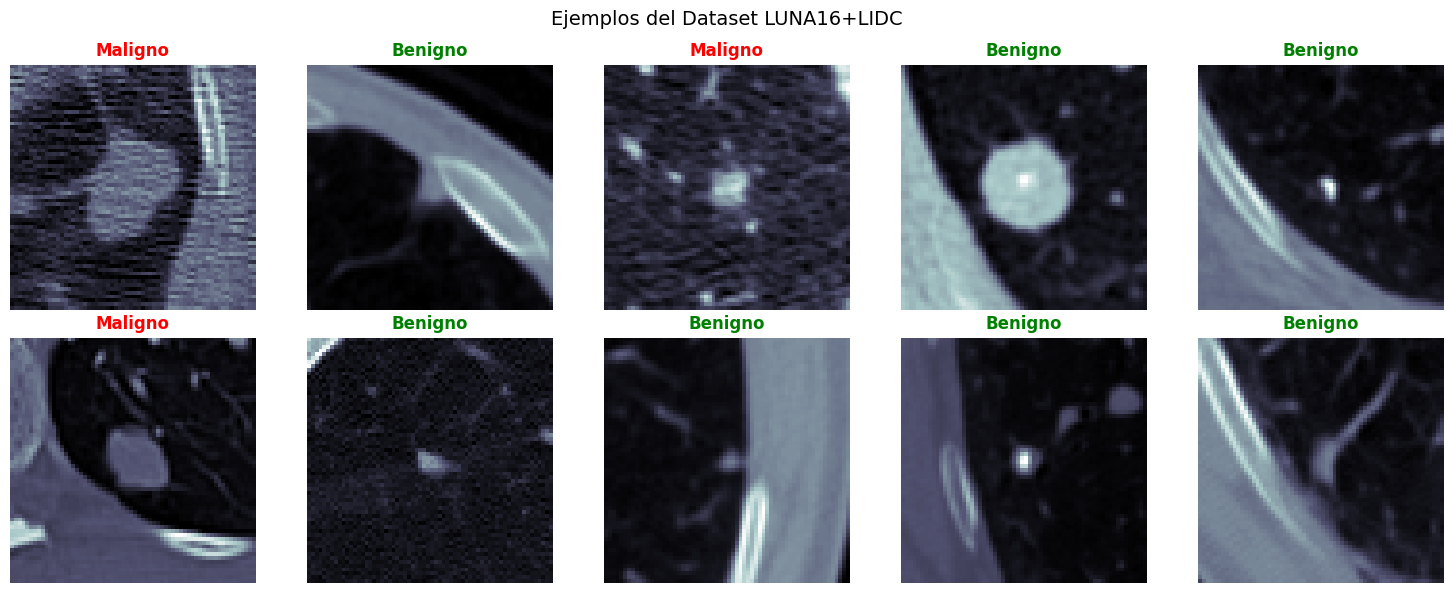

In [25]:
# Visualizar ejemplos del dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

class_names = ['Benigno', 'Maligno']
colors = ['green', 'red']

# Crear dataset temporal para visualizacion
temp_dataset = NoduleDataset(X, y, augment=False)

for i in range(10):
    idx = i * (len(temp_dataset) // 10)
    patch, label = temp_dataset[idx]
    
    axes[i].imshow(patch.squeeze().numpy(), cmap='bone')
    axes[i].set_title(f'{class_names[label]}', color=colors[label], fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Ejemplos del Dataset LUNA16+LIDC', fontsize=14)
plt.tight_layout()
plt.show()

---

## 4. Estrategia 1: Backbone Congelado + Cabeza Lineal

**ResNet18 pre-entrenado con backbone congelado**:
- Solo entrenamos la capa final (~1000 parametros vs 11M)
- Evita overfitting severo en datasets pequenos
- El backbone actua como extractor de features generalistas

In [26]:
def create_frozen_resnet18(num_classes=2, dropout=0.5):
    """
    Crea ResNet18 con backbone congelado y cabeza lineal entrenable
    
    Solo ~1000 parametros entrenables (512*2 + 2 = 1026)
    """
    # Cargar ResNet18 pre-entrenado adaptado para grayscale
    model = timm.create_model('resnet18', pretrained=True, in_chans=1)
    
    # Congelar todo el backbone
    for param in model.parameters():
        param.requires_grad = False
    
    # Reemplazar cabeza con capa entrenable
    num_features = model.fc.in_features  # 512 para ResNet18
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_features, num_classes)
    )
    
    # La nueva cabeza SI tiene requires_grad=True por defecto
    return model


# Crear modelo y mostrar info
model_demo = create_frozen_resnet18()

n_total = sum(p.numel() for p in model_demo.parameters())
n_trainable = sum(p.numel() for p in model_demo.parameters() if p.requires_grad)
n_frozen = n_total - n_trainable

print("ResNet18 con Backbone Congelado:")
print(f"  Parametros totales: {n_total:,}")
print(f"  Parametros congelados: {n_frozen:,}")
print(f"  Parametros entrenables: {n_trainable:,}")
print(f"  Reduccion: {n_frozen/n_total:.1%} de parametros NO se entrenan")

del model_demo

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet18 con Backbone Congelado:
  Parametros totales: 11,171,266
  Parametros congelados: 11,170,240
  Parametros entrenables: 1,026
  Reduccion: 100.0% de parametros NO se entrenan


c:\Users\Poney\Desktop\Imagenes Biomedicas\.venv\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Poney\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


---

## 5. Entrenamiento con K-Fold Cross-Validation

Entrenamos el modelo con K-Fold CV por paciente y reportamos media +/- std.

In [27]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Entrena una epoca"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for patches, labels in loader:
        patches = patches.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total


def evaluate(model, loader, device):
    """Evalua el modelo y retorna predicciones"""
    model.eval()
    all_probs = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for patches, labels in loader:
            patches = patches.to(device)
            
            outputs = model(patches)
            probs = F.softmax(outputs, dim=1)[:, 1]
            _, predicted = outputs.max(1)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


def train_kfold_resnet(X, y, groups, n_folds=5, num_epochs=30, lr=1e-3, batch_size=16, verbose=True):
    """
    Entrena ResNet18 congelado con K-Fold CV por paciente
    
    Returns:
        fold_results: Lista de diccionarios con metricas por fold
    """
    skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    fold_results = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y, groups)):
        if verbose:
            print(f"\n{'='*50}")
            print(f"Fold {fold_idx+1}/{n_folds}")
            print(f"{'='*50}")
        
        # Crear dataloaders
        train_loader, val_loader = create_fold_loaders(X, y, train_idx, val_idx, batch_size)
        
        # Crear modelo fresco para cada fold
        model = create_frozen_resnet18().to(device)
        
        # Solo optimizar parametros de la cabeza
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=lr
        )
        criterion = nn.CrossEntropyLoss()
        
        best_auc = 0
        patience = 5
        patience_counter = 0
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            y_true, y_pred, y_prob = evaluate(model, val_loader, device)
            
            try:
                val_auc = roc_auc_score(y_true, y_prob)
            except:
                val_auc = 0.5
            
            val_acc = accuracy_score(y_true, y_pred)
            
            if verbose and (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1:02d}: Train Loss={train_loss:.3f}, "
                      f"Train Acc={train_acc:.1%}, Val Acc={val_acc:.1%}, Val AUC={val_auc:.3f}")
            
            if val_auc > best_auc:
                best_auc = val_auc
                best_results = {'y_true': y_true, 'y_pred': y_pred, 'y_prob': y_prob}
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose:
                    print(f"  [INFO] Early stopping at epoch {epoch+1}")
                break
        
        # Calcular metricas del fold
        y_true = best_results['y_true']
        y_pred = best_results['y_pred']
        y_prob = best_results['y_prob']
        
        fold_metrics = {
            'fold': fold_idx + 1,
            'auc': roc_auc_score(y_true, y_prob),
            'accuracy': accuracy_score(y_true, y_pred),
            'sensitivity': recall_score(y_true, y_pred, pos_label=1),
            'specificity': recall_score(y_true, y_pred, pos_label=0),
            'y_true': y_true,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        fold_results.append(fold_metrics)
        
        if verbose:
            print(f"  Fold {fold_idx+1} - AUC: {fold_metrics['auc']:.3f}, "
                  f"Acc: {fold_metrics['accuracy']:.1%}")
    
    return fold_results


print("[OK] Funciones de entrenamiento definidas")

[OK] Funciones de entrenamiento definidas


In [28]:
# ============================================================
# ENTRENAR RESNET18 CONGELADO CON K-FOLD CV
# ============================================================
print("Entrenando ResNet18 (backbone congelado) con K-Fold CV...")
print(f"  K = {N_FOLDS} folds")
print(f"  Epochs max = 30")
print(f"  Early stopping = 5 epochs")

resnet_results = train_kfold_resnet(
    X, y, groups,
    n_folds=N_FOLDS,
    num_epochs=30,
    lr=1e-3,
    batch_size=16,
    verbose=True
)

# Calcular estadisticas
resnet_aucs = [r['auc'] for r in resnet_results]
resnet_accs = [r['accuracy'] for r in resnet_results]
resnet_sens = [r['sensitivity'] for r in resnet_results]
resnet_spec = [r['specificity'] for r in resnet_results]

print("\n" + "="*60)
print("RESULTADOS: ResNet18 Backbone Congelado")
print("="*60)
print(f"  AUC:         {np.mean(resnet_aucs):.3f} +/- {np.std(resnet_aucs):.3f}")
print(f"  Accuracy:    {np.mean(resnet_accs):.3f} +/- {np.std(resnet_accs):.3f}")
print(f"  Sensitivity: {np.mean(resnet_sens):.3f} +/- {np.std(resnet_sens):.3f}")
print(f"  Specificity: {np.mean(resnet_spec):.3f} +/- {np.std(resnet_spec):.3f}")


Entrenando ResNet18 (backbone congelado) con K-Fold CV...
  K = 5 folds
  Epochs max = 30
  Early stopping = 5 epochs

Fold 1/5
  Epoch 05: Train Loss=0.551, Train Acc=70.6%, Val Acc=69.8%, Val AUC=0.790
  Epoch 10: Train Loss=0.481, Train Acc=74.9%, Val Acc=72.1%, Val AUC=0.794
  Epoch 15: Train Loss=0.560, Train Acc=73.6%, Val Acc=70.9%, Val AUC=0.808
  Epoch 20: Train Loss=0.422, Train Acc=80.3%, Val Acc=77.9%, Val AUC=0.834
  [INFO] Early stopping at epoch 21
  Fold 1 - AUC: 0.848, Acc: 75.6%

Fold 2/5
  Epoch 05: Train Loss=0.542, Train Acc=72.9%, Val Acc=83.1%, Val AUC=0.864
  Epoch 10: Train Loss=0.530, Train Acc=75.5%, Val Acc=78.9%, Val AUC=0.893
  Epoch 15: Train Loss=0.500, Train Acc=79.6%, Val Acc=85.9%, Val AUC=0.934
  Epoch 20: Train Loss=0.511, Train Acc=74.2%, Val Acc=83.1%, Val AUC=0.922
  [INFO] Early stopping at epoch 20
  Fold 2 - AUC: 0.934, Acc: 85.9%

Fold 3/5
  Epoch 05: Train Loss=0.534, Train Acc=73.2%, Val Acc=82.7%, Val AUC=0.849
  Epoch 10: Train Loss=0.574

---

## 6. Estrategia 2: Features CNN + Clasificadores Clasicos

Extraemos embeddings del backbone y entrenamos clasificadores clasicos:
- **SVM (RBF)**: Bueno para datos no lineales
- **Logistic Regression**: Regularizado para evitar overfitting
- **Random Forest**: Ensemble con profundidad limitada

In [29]:
def extract_features_resnet(X, batch_size=32):
    """
    Extrae features usando ResNet18 backbone congelado
    
    Returns:
        features: Array (N, 512) de embeddings
    """
    # Crear modelo extractor (sin cabeza final)
    backbone = timm.create_model('resnet18', pretrained=True, in_chans=1, num_classes=0)
    backbone = backbone.to(device)
    backbone.eval()
    
    # Dataset simple sin augmentation
    dataset = NoduleDataset(X, np.zeros(len(X)), augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    features = []
    with torch.no_grad():
        for patches, _ in tqdm(loader, desc="Extrayendo features"):
            patches = patches.to(device)
            feat = backbone(patches)  # (batch, 512)
            features.append(feat.cpu().numpy())
    
    return np.vstack(features)


def train_kfold_classical(X_features, y, groups, n_folds=5, verbose=True):
    """
    Entrena clasificadores clasicos con K-Fold CV
    
    Returns:
        results: Dict con resultados por clasificador
    """
    skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    classifiers = {
        'SVM (RBF)': SVC(kernel='rbf', C=1.0, probability=True, random_state=SEED),
        'Logistic Regression': LogisticRegression(C=0.1, max_iter=1000, random_state=SEED),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=SEED)
    }
    
    results = {name: [] for name in classifiers.keys()}
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_features, y, groups)):
        X_train, y_train = X_features[train_idx], y[train_idx]
        X_val, y_val = X_features[val_idx], y[val_idx]
        
        # Normalizar features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        for name, clf_template in classifiers.items():
            # Crear nueva instancia del clasificador
            if 'SVM' in name:
                clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=SEED)
            elif 'Logistic' in name:
                clf = LogisticRegression(C=0.1, max_iter=1000, random_state=SEED)
            else:
                clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=SEED)
            
            # Entrenar
            clf.fit(X_train_scaled, y_train)
            
            # Evaluar
            y_pred = clf.predict(X_val_scaled)
            y_prob = clf.predict_proba(X_val_scaled)[:, 1]
            
            try:
                auc = roc_auc_score(y_val, y_prob)
            except:
                auc = 0.5
            
            fold_metrics = {
                'fold': fold_idx + 1,
                'auc': auc,
                'accuracy': accuracy_score(y_val, y_pred),
                'sensitivity': recall_score(y_val, y_pred, pos_label=1),
                'specificity': recall_score(y_val, y_pred, pos_label=0),
                'y_true': y_val,
                'y_pred': y_pred,
                'y_prob': y_prob
            }
            results[name].append(fold_metrics)
        
        if verbose:
            print(f"Fold {fold_idx+1}/{n_folds} completado")
    
    return results


print("[OK] Funciones de extraccion de features definidas")

[OK] Funciones de extraccion de features definidas


In [30]:
# ============================================================
# EXTRAER FEATURES Y ENTRENAR CLASIFICADORES CLASICOS
# ============================================================
print("Extrayendo features con ResNet18 backbone...")
X_features = extract_features_resnet(X_trainval)
print(f"[OK] Features extraidas: {X_features.shape}")

print("\nEntrenando clasificadores clasicos con K-Fold CV...")
classical_results = train_kfold_classical(X_features, y_trainval, groups_trainval, n_folds=N_FOLDS, verbose=True)

# Mostrar resultados
print("\n" + "="*60)
print("RESULTADOS: Clasificadores Clasicos (Features CNN)")
print("="*60)

for clf_name, fold_results in classical_results.items():
    aucs = [r['auc'] for r in fold_results]
    accs = [r['accuracy'] for r in fold_results]
    sens = [r['sensitivity'] for r in fold_results]
    spec = [r['specificity'] for r in fold_results]
    
    print(f"\n{clf_name}:")
    print(f"  AUC:         {np.mean(aucs):.3f} +/- {np.std(aucs):.3f}")
    print(f"  Accuracy:    {np.mean(accs):.3f} +/- {np.std(accs):.3f}")
    print(f"  Sensitivity: {np.mean(sens):.3f} +/- {np.std(sens):.3f}")
    print(f"  Specificity: {np.mean(spec):.3f} +/- {np.std(spec):.3f}")


Extrayendo features con ResNet18 backbone...


Extrayendo features: 100%|██████████| 13/13 [00:00<00:00, 42.10it/s]


[OK] Features extraidas: (385, 512)

Entrenando clasificadores clasicos con K-Fold CV...
Fold 1/5 completado
Fold 2/5 completado
Fold 3/5 completado
Fold 4/5 completado
Fold 5/5 completado

RESULTADOS: Clasificadores Clasicos (Features CNN)

SVM (RBF):
  AUC:         0.794 +/- 0.049
  Accuracy:    0.706 +/- 0.043
  Sensitivity: 0.717 +/- 0.063
  Specificity: 0.686 +/- 0.045

Logistic Regression:
  AUC:         0.798 +/- 0.054
  Accuracy:    0.739 +/- 0.060
  Sensitivity: 0.719 +/- 0.058
  Specificity: 0.756 +/- 0.064

Random Forest:
  AUC:         0.824 +/- 0.054
  Accuracy:    0.763 +/- 0.037
  Sensitivity: 0.775 +/- 0.066
  Specificity: 0.760 +/- 0.029


---

## 7. Estrategia 3: Radiomics Baseline (Features interpretables)

Features clasicas de imagen medica sin deep learning:
- **Intensidad**: estadisticas basicas (media, std, percentiles)
- **Textura GLCM**: contraste, homogeneidad, energia, correlacion
- **Histograma**: skewness, kurtosis

In [31]:
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis


def extract_radiomics(patch):
    """
    Extrae features radiomicas de un patch 2D
    
    Returns:
        Dict con todas las features
    """
    features = {}
    
    # Normalizar a 0-255 para GLCM
    patch_norm = patch - patch.min()
    if patch_norm.max() > 0:
        patch_norm = patch_norm / patch_norm.max()
    patch_uint8 = (patch_norm * 255).astype(np.uint8)
    
    # --- INTENSIDAD ---
    features['intensity_mean'] = float(patch.mean())
    features['intensity_std'] = float(patch.std())
    features['intensity_min'] = float(patch.min())
    features['intensity_max'] = float(patch.max())
    features['intensity_p25'] = float(np.percentile(patch, 25))
    features['intensity_p50'] = float(np.percentile(patch, 50))
    features['intensity_p75'] = float(np.percentile(patch, 75))
    
    # --- HISTOGRAMA ---
    features['skewness'] = float(skew(patch.flatten()))
    features['kurtosis'] = float(kurtosis(patch.flatten()))
    
    # --- TEXTURA GLCM ---
    # Calcular GLCM en 4 direcciones (0, 45, 90, 135 grados)
    try:
        glcm = graycomatrix(patch_uint8, distances=[1], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=256, symmetric=True, normed=True)
        
        features['glcm_contrast'] = float(graycoprops(glcm, 'contrast').mean())
        features['glcm_homogeneity'] = float(graycoprops(glcm, 'homogeneity').mean())
        features['glcm_energy'] = float(graycoprops(glcm, 'energy').mean())
        features['glcm_correlation'] = float(graycoprops(glcm, 'correlation').mean())
        features['glcm_dissimilarity'] = float(graycoprops(glcm, 'dissimilarity').mean())
    except:
        # Valores por defecto si falla
        features['glcm_contrast'] = 0.0
        features['glcm_homogeneity'] = 1.0
        features['glcm_energy'] = 1.0
        features['glcm_correlation'] = 0.0
        features['glcm_dissimilarity'] = 0.0
    
    return features


def extract_all_radiomics(X):
    """Extrae features radiomicas de todos los patches"""
    all_features = []
    
    for i, patch in enumerate(tqdm(X, desc="Extrayendo radiomics")):
        features = extract_radiomics(patch)
        all_features.append(features)
    
    # Convertir a DataFrame
    df = pd.DataFrame(all_features)
    return df.values, list(df.columns)


print("[OK] Funciones de radiomics definidas")
print(f"Features por patch: {len(extract_radiomics(X[0]))}")

[OK] Funciones de radiomics definidas
Features por patch: 14


In [35]:
# ============================================================
# EXTRAER RADIOMICS Y ENTRENAR CLASIFICADORES
# ============================================================
print("Extrayendo features radiomicas...")
X_radiomics, feature_names = extract_all_radiomics(X_trainval)
print(f"[OK] Features extraidas: {X_radiomics.shape}")
print(f"Features: {feature_names}")

print("\nEntrenando clasificadores con Radiomics...")
radiomics_results = train_kfold_classical(X_radiomics, y_trainval, groups_trainval, n_folds=N_FOLDS, verbose=True)

# Mostrar resultados
print("\n" + "="*60)
print("RESULTADOS: Clasificadores con Radiomics")
print("="*60)

for clf_name, fold_results in radiomics_results.items():
    aucs = [r['auc'] for r in fold_results]
    accs = [r['accuracy'] for r in fold_results]
    sens = [r['sensitivity'] for r in fold_results]
    spec = [r['specificity'] for r in fold_results]
    
    print(f"\n{clf_name}:")
    print(f"  AUC:         {np.mean(aucs):.3f} +/- {np.std(aucs):.3f}")
    print(f"  Accuracy:    {np.mean(accs):.3f} +/- {np.std(accs):.3f}")
    print(f"  Sensitivity: {np.mean(sens):.3f} +/- {np.std(sens):.3f}")
    print(f"  Specificity: {np.mean(spec):.3f} +/- {np.std(spec):.3f}")


Extrayendo features radiomicas...


Extrayendo radiomics: 100%|██████████| 385/385 [00:15<00:00, 25.44it/s]


[OK] Features extraidas: (385, 14)
Features: ['intensity_mean', 'intensity_std', 'intensity_min', 'intensity_max', 'intensity_p25', 'intensity_p50', 'intensity_p75', 'skewness', 'kurtosis', 'glcm_contrast', 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation', 'glcm_dissimilarity']

Entrenando clasificadores con Radiomics...
Fold 1/5 completado
Fold 2/5 completado
Fold 3/5 completado
Fold 4/5 completado
Fold 5/5 completado

RESULTADOS: Clasificadores con Radiomics

SVM (RBF):
  AUC:         0.813 +/- 0.056
  Accuracy:    0.709 +/- 0.055
  Sensitivity: 0.769 +/- 0.053
  Specificity: 0.647 +/- 0.083

Logistic Regression:
  AUC:         0.808 +/- 0.070
  Accuracy:    0.714 +/- 0.069
  Sensitivity: 0.754 +/- 0.050
  Specificity: 0.668 +/- 0.102

Random Forest:
  AUC:         0.814 +/- 0.058
  Accuracy:    0.734 +/- 0.053
  Sensitivity: 0.763 +/- 0.010
  Specificity: 0.692 +/- 0.107


---

## 8. Comparacion de Todas las Estrategias

Tabla resumen con media +/- std de AUC sobre K folds.

In [36]:
# ============================================================
# TABLA COMPARATIVA DE TODAS LAS ESTRATEGIAS
# ============================================================
from IPython.display import display, HTML

def summarize_results(results_list, name):
    """Resume metricas de una lista de resultados por fold"""
    aucs = [r['auc'] for r in results_list]
    accs = [r['accuracy'] for r in results_list]
    sens = [r['sensitivity'] for r in results_list]
    spec = [r['specificity'] for r in results_list]
    return {
        'Metodo': name,
        'AUC': f"{np.mean(aucs):.3f} +/- {np.std(aucs):.3f}",
        'Accuracy': f"{np.mean(accs):.3f} +/- {np.std(accs):.3f}",
        'Sensitivity': f"{np.mean(sens):.3f} +/- {np.std(sens):.3f}",
        'Specificity': f"{np.mean(spec):.3f} +/- {np.std(spec):.3f}",
        'auc_mean': np.mean(aucs)
    }

# Recopilar todos los resultados
all_results = []

# 1. ResNet18 Backbone Congelado
all_results.append(summarize_results(resnet_results, 'ResNet18 (frozen)'))

# 2. Clasificadores con features CNN
for clf_name, fold_results in classical_results.items():
    short_name = clf_name.replace(' (RBF)', '').replace(' Regression', '')
    all_results.append(summarize_results(fold_results, f'CNN + {short_name}'))

# 3. Clasificadores con Radiomics
for clf_name, fold_results in radiomics_results.items():
    short_name = clf_name.replace(' (RBF)', '').replace(' Regression', '')
    all_results.append(summarize_results(fold_results, f'Radiomics + {short_name}'))

# Ordenar por AUC descendente
all_results.sort(key=lambda x: x['auc_mean'], reverse=True)

# Crear DataFrame
df_results = pd.DataFrame(all_results)
df_results = df_results.drop(columns=['auc_mean'])
df_results.index = range(1, len(df_results) + 1)  # Ranking 1, 2, 3...
df_results.index.name = 'Rank'

# Titulo
print(f"\n{'='*70}")
print(f" COMPARACION DE ESTRATEGIAS - K-Fold CV (K={N_FOLDS})")
print(f" Dataset: {len(X)} patches | {len(np.unique(groups))} pacientes")
print(f"{'='*70}\n")

# Mostrar tabla con estilo
styled = df_results.style.set_properties(**{
    'text-align': 'center',
    'font-size': '11pt'
}).set_properties(subset=['Metodo'], **{
    'text-align': 'left',
    'font-weight': 'bold'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]},
    {'selector': 'tr:first-child', 'props': [('background-color', '#d4edda')]}  # Verde para el mejor
])

display(styled)

# Resumen
best = all_results[0]
print(f"\n[MEJOR] {best['Metodo']}: AUC = {best['AUC']}")


 COMPARACION DE ESTRATEGIAS - K-Fold CV (K=5)
 Dataset: 385 patches | 290 pacientes



,Metodo,AUC,Accuracy,Sensitivity,Specificity
Rank,,,,,
1,ResNet18 (frozen),0.850 +/- 0.053,0.768 +/- 0.066,0.734 +/- 0.121,0.817 +/- 0.050
2,CNN + Random Forest,0.824 +/- 0.054,0.763 +/- 0.037,0.775 +/- 0.066,0.760 +/- 0.029
3,Radiomics + Random Forest,0.814 +/- 0.058,0.734 +/- 0.053,0.763 +/- 0.010,0.692 +/- 0.107
4,Radiomics + SVM,0.813 +/- 0.056,0.709 +/- 0.055,0.769 +/- 0.053,0.647 +/- 0.083
5,Radiomics + Logistic,0.808 +/- 0.070,0.714 +/- 0.069,0.754 +/- 0.050,0.668 +/- 0.102
6,CNN + Logistic,0.798 +/- 0.054,0.739 +/- 0.060,0.719 +/- 0.058,0.756 +/- 0.064
7,CNN + SVM,0.794 +/- 0.049,0.706 +/- 0.043,0.717 +/- 0.063,0.686 +/- 0.045



[MEJOR] ResNet18 (frozen): AUC = 0.850 +/- 0.053


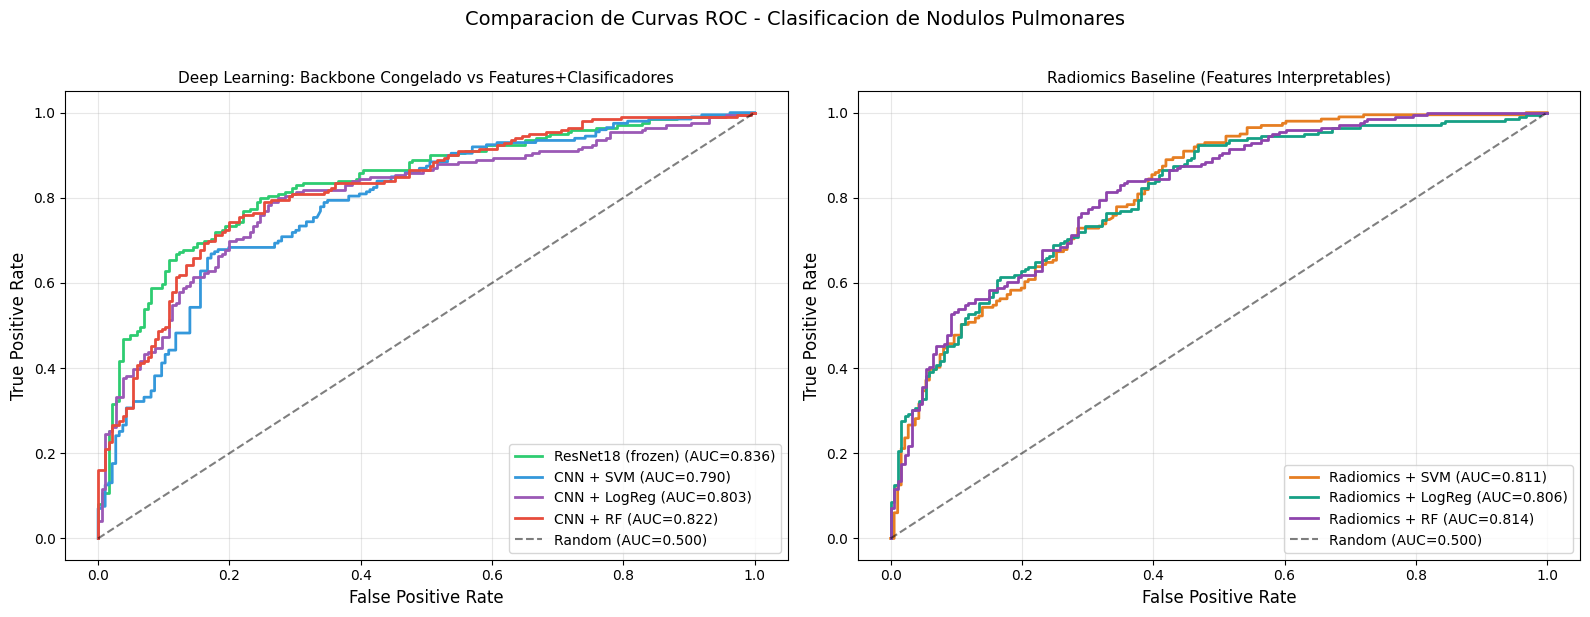


[OK] Notebook completado


In [37]:
# ============================================================
# VISUALIZACION: CURVAS ROC COMPARATIVAS
# ============================================================

# Preparar datos para ROC (usamos el ultimo fold como ejemplo representativo)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Panel 1: Deep Learning vs Clasificadores Clasicos ---
ax1 = axes[0]

# ResNet18 (promediamos sobre folds)
colors_dl = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
methods_dl = [
    ('ResNet18 (frozen)', resnet_results),
    ('CNN + SVM', classical_results['SVM (RBF)']),
    ('CNN + LogReg', classical_results['Logistic Regression']),
    ('CNN + RF', classical_results['Random Forest'])
]

for i, (name, results) in enumerate(methods_dl):
    # Concatenar y_true y y_prob de todos los folds
    y_true_all = np.concatenate([r['y_true'] for r in results])
    y_prob_all = np.concatenate([r['y_prob'] for r in results])
    
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    auc = roc_auc_score(y_true_all, y_prob_all)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=colors_dl[i], linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.500)')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('Deep Learning: Backbone Congelado vs Features+Clasificadores', fontsize=11)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# --- Panel 2: Radiomics Baseline ---
ax2 = axes[1]

colors_rad = ['#e67e22', '#16a085', '#8e44ad']
methods_rad = [
    ('Radiomics + SVM', radiomics_results['SVM (RBF)']),
    ('Radiomics + LogReg', radiomics_results['Logistic Regression']),
    ('Radiomics + RF', radiomics_results['Random Forest'])
]

for i, (name, results) in enumerate(methods_rad):
    y_true_all = np.concatenate([r['y_true'] for r in results])
    y_prob_all = np.concatenate([r['y_prob'] for r in results])
    
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    auc = roc_auc_score(y_true_all, y_prob_all)
    ax2.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=colors_rad[i], linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.500)')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Radiomics Baseline (Features Interpretables)', fontsize=11)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparacion de Curvas ROC - Clasificacion de Nodulos Pulmonares', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n[OK] Notebook completado")

In [38]:
# ============================================================
# GUARDAR MEJORES MODELOS
# ============================================================
import joblib

print("Guardando modelos entrenados...")
print(f"Directorio: {weights_dir}")

# 1. Entrenar modelo ResNet18 final en todo el dataset
print("\n[1/3] Entrenando ResNet18 final en todo el dataset...")
final_model = create_frozen_resnet18().to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, final_model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Dataset completo
full_dataset = NoduleDataset(X, y, augment=True)
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True, num_workers=0)

# Entrenar 20 epochs
for epoch in range(20):
    train_loss, train_acc = train_epoch(final_model, full_loader, criterion, optimizer, device)
    if (epoch + 1) % 5 == 0:
        print(f"  Epoch {epoch+1}: Loss={train_loss:.3f}, Acc={train_acc:.1%}")

# Guardar pesos PyTorch
resnet_path = os.path.join(weights_dir, 'resnet18_frozen_classifier.pth')
torch.save(final_model.state_dict(), resnet_path)
print(f"  [OK] ResNet18: {resnet_path}")

# 2. Entrenar y guardar clasificadores clasicos en todo el dataset
print("\n[2/3] Entrenando clasificadores clasicos en todo el dataset...")
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# SVM
svm_clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=SEED)
svm_clf.fit(X_features_scaled, y)
svm_path = os.path.join(weights_dir, 'svm_classifier.joblib')
joblib.dump({'model': svm_clf, 'scaler': scaler}, svm_path)
print(f"  [OK] SVM: {svm_path}")

# Logistic Regression
logreg_clf = LogisticRegression(C=0.1, max_iter=1000, random_state=SEED)
logreg_clf.fit(X_features_scaled, y)
logreg_path = os.path.join(weights_dir, 'logreg_classifier.joblib')
joblib.dump({'model': logreg_clf, 'scaler': scaler}, logreg_path)
print(f"  [OK] LogReg: {logreg_path}")

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=SEED)
rf_clf.fit(X_features_scaled, y)
rf_path = os.path.join(weights_dir, 'rf_classifier.joblib')
joblib.dump({'model': rf_clf, 'scaler': scaler}, rf_path)
print(f"  [OK] Random Forest: {rf_path}")

# 3. Guardar scaler de radiomics
print("\n[3/3] Guardando scaler de Radiomics...")
scaler_radiomics = StandardScaler()
scaler_radiomics.fit(X_radiomics)
radiomics_path = os.path.join(weights_dir, 'radiomics_scaler.joblib')
joblib.dump({'scaler': scaler_radiomics, 'feature_names': feature_names}, radiomics_path)
print(f"  [OK] Radiomics scaler: {radiomics_path}")

print("\n" + "="*60)
print("MODELOS GUARDADOS")
print("="*60)
print(f"\nArchivos en {weights_dir}:")
for f in os.listdir(weights_dir):
    if f.endswith(('.pth', '.joblib')):
        size = os.path.getsize(os.path.join(weights_dir, f)) / 1024
        print(f"  - {f} ({size:.1f} KB)")

Guardando modelos entrenados...
Directorio: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights

[1/3] Entrenando ResNet18 final en todo el dataset...
  Epoch 5: Loss=0.518, Acc=72.5%
  Epoch 10: Loss=0.518, Acc=75.6%
  Epoch 15: Loss=0.520, Acc=76.1%
  Epoch 20: Loss=0.541, Acc=76.1%
  [OK] ResNet18: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\resnet18_frozen_classifier.pth

[2/3] Entrenando clasificadores clasicos en todo el dataset...
  [OK] SVM: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\svm_classifier.joblib
  [OK] LogReg: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\logreg_classifier.joblib
  [OK] Random Forest: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\rf_classifier.joblib

[3/3] Guardando scaler de Radiomics...
  [OK] Radiomics scaler: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\radiomics_scaler.joblib

MODELOS GUARDADOS

Archivos en c:\Users\Poney\Desktop\Imagenes Biomedicas\weights:
  - densenet121_nodules.pth (27755.0 KB)
  - efficientnet_